# Importing and calling data files


In [402]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import reionizer
import astropy
import astropy.cosmology
from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const
from scipy import interpolate


#Call UV LF data files
LFz_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' #calls directory
LFz_dir = LFz_data_dir+'MTT15_UVLF/LF_pred/' #inside models folder call MTT15_UVLF/LF_pred/ folder
LFz_files = sorted(reionizer.insensitive_glob(LFz_dir+'LF_pred_z*.txt')) 
#calls each file in modelled data * will be replaced with corresponding zval

#Calling EW files and their Muv values
pW_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
pW_dir = pW_data_dir+'M18_z=7.0_lnpWobs_Muv/' #inside models folder call M18_z=7.0_lnpWobs_Muv folder
pW_files = sorted(reionizer.insensitive_glob(pW_dir+'ln_pWobs_*.txt')) #calls each file in modelled data * will be replaced with corresponding xHI

# Methodology
## Defining function to call files


In [403]:
#Function used to load files
def load_uvf_pandas(ufl_filename): 
    """
    Load table into pandas df
    """
    uvf_tab_df = pd.read_csv(ufl_filename, skiprows=1, delim_whitespace=True)
    
    # Shuffle the column names to remove the '#' from the first column
    uvf_tab_df.columns = np.roll(uvf_tab_df.columns, -1)

    # Cut off the last (empty) column
    uvf_tab_df = uvf_tab_df.iloc[:, :-1]

    return uvf_tab_df



#Call UV LF files by calling file name at specific z value 
LFz_tab = np.array([float(f.split('LF_pred_z')[-1].split('.txt')[0]) for f in LFz_files]) 


#Call xHI, EW files
xHI_tab = np.array([float(f.split('xHI=')[-1].split('.txt')[0]) for f in pW_files]) 


#Call EW file with xHI = 0.01 
pW_tab = load_uvf_pandas(pW_files[0]) 

#Get Muv values from EW file as an array to use
Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])

## Defining constants and evaluating equations for given z value. Interpolating data between UV LF and Lya EW

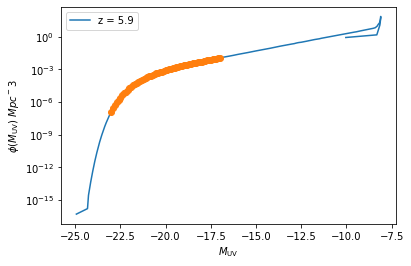

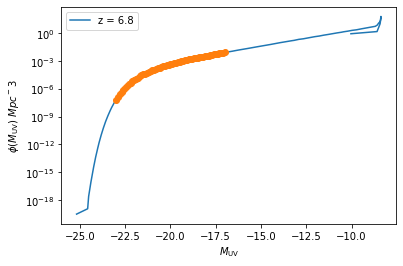

In [483]:
#Constants and constraints
xHI_array = np.array([0.01]) #chosen xHI value
zval_test = np.array([5.9,6.8]) #chosen redshifts
Muv_array = np.array([-18.0,-22.0])
beta = -2.0 #usually -2 for high z galaxies as per spectrum as power law
pc_10 = 10 * u.pc #1 pc to Mpc
wl_lya = 1216 * u.Angstrom #angstrom
wl_uv = 1500 * u.Angstrom #angstrom
f0 = 3.631e-23 * (u.erg/u.s) * (u.cm**(-2)) * (u.Hz**(-1)) #flux_0 in erg s^-1 cm^-2 Hz^-1
c = const.c #speed of light


for zz,zval2 in enumerate (LFz_tab): 
    if zval2 in zval_test:
        
        LF_tab = load_uvf_pandas(LFz_files[zz]) #load in files
        
        #Interpolating UV LF Muv and ndens values into a 1d array
        LF_interp = interpolate.interp1d(LF_tab['Muv'],LF_tab['ndens']) #old values
        new_ndens = LF_interp(Muv_EW)
        
        #Get Muv values from file as an array to use
        Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])
        d_l = P15.luminosity_distance(zval2) #define distance modulus

        #Define apparent magnitude equation
        def muv(Muv_EW,d_l,zval2): 
            p1 = Muv_EW
            p2 = 5*(np.log10((d_l/pc_10).to(u.pc/u.pc))) #convert d_l/pc_10 to pc units and then dimensionless
            p3 = 2.5*(beta+1.0)*np.log10(zval2+1.0)
            ans = p1 + p2 + p3
            
            return ans
        muv = muv(Muv_EW,d_l,zval2)
        
        
        #Flux density of UV continuum at Lya wavelength from Muv for given zvals
        fd_uv = f0 * (10**(-0.4*muv)) *(c/(wl_lya**2)) *((wl_lya/wl_uv)**(beta+2.0))
        fd_units = fd_uv.to(u.erg/u.s* (u.cm**(-2))/u.Angstrom) ##use this to show units
        
        #Jacobian - partial EW / partial Lya Luminosity for given zvals 
        jacobian = 1/((4*np.pi*d_l**2.)*fd_units)
        
        for xx,xHI in enumerate (xHI_tab): #for each index and corresponding xHI value in list of xHI, call specific data file
            if xHI in xHI_array:
                pW_tab = load_uvf_pandas(pW_files[xx])
                new_pW_tab = pW_tab.drop('W',axis=1)
                
                #EW values for each Muv in EW file
                EW_vals = np.array(new_pW_tab) 
                
                # P(Lya|Muv)
                pLya = jacobian * EW_vals #Jacobian (1D) * EW_vals (2D) = pLya (2D) 
                
                # UV ndens, phi(Muv) * P(Lya|Muv)
                product = new_ndens * pLya #Similarly, new_ndens(1D) * pLya (2D) = product (2D)
                
                # Flux_Lya
                f_lya = EW_vals * fd_units
                
                #Luminosity_Lya
                lum_lya = f_lya * (4*np.pi*d_l**2.)
                
                
#                 if xHI==0.01:
#                     my_color = 'gray'
#                 else:
#                     my_color = 'purple'    
#         #Within if statement, this is for identifying xHI legend (values and corresponding colors)
#                 for mm,Muv in enumerate (Muv_array):
#                     if mm == 0: #first item in Muv_array, i.e. -18.0 (will show xHI values and corresponding colors as solid)
#                         label = r'$\overline{x}_\mathrm{HI} = %.2f$' % xHI
#                         ls = 'solid'
#                     else: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
#                         label = None
#                         ls = 'dashed'
#                     plt.plot(lum_lya, pW_tab[f'{Muv}'], ls=ls, color = my_color)


        # Plot UV LF values vs interpolated Muv that is the same as EW 
        plt.semilogy(LF_tab['Muv'],LF_tab['ndens'],label = 'z = %.1f'%zval2) #UV LF values (181 Muv vals)
        plt.plot(Muv_EW,new_ndens,'o')#EW Values along UV LF plot (61 Muv vals)
        #Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 
        plt.legend()
        plt.xlabel('$M_\mathrm{UV}$')
        plt.ylabel(r'$\phi(M_\mathrm{UV})\ Mpc^-3$')
        plt.show()


        ## Plot jacobian vs Muv
        # Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
        # As Muv becomes fainter, value for jacobian increases, they're inversely proportional?
#         plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval2)
        
# plt.legend()
# plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
# plt.ylabel('$M_\mathrm{UV}$')
# plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
        
# #Save the figure
# plt.savefig('JvsMuv.pdf', dpi=300, bbox_inches='tight')

# plt.show()
        

        

# Test 

In [484]:
#TEST integration
lower = np.amin(Muv_EW)
upper = np.amax(Muv_EW)
limits = np.array([lower,upper])
integral = np.trapz(product, x = limits, dx = Muv_EW)
print(integral.shape)

(10000,)


In [373]:
#TEST
Muv_18 = Muv_EW[10]
Muv_22 = Muv_EW[50]
Muv_test = np.array([Muv_18,Muv_22])
print(Muv_test)

[-22. -18.]


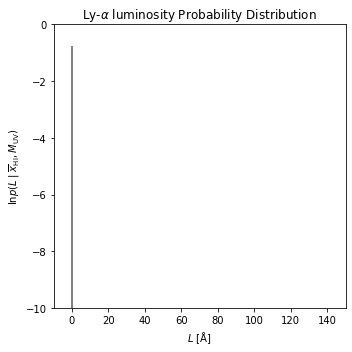

In [375]:
# PLOT TEST with Lum_Lya and Certain Muv - similar to EW plot
plt.figure(figsize=(5,5))
xHI_array = np.array([0.01])
Muv_array = np.array([-18.0,-22.0])

#For loop, regarding xHI and Muv
        
for xx,xHI in enumerate (xHI_tab): #for each index and corresponding xHI value in list of xHI, call specific data file
    if xHI in xHI_array:
        pW_tab = load_uvf_pandas(pW_files[xx]) #when all files are called, if the value run is within the array, then call that data file
        if xHI==0.01:
            my_color = 'gray'
        else:
            my_color = 'purple'    
        #Within if statement, this is for identifying xHI legend (values and corresponding colors)
        for mm,Muv in enumerate (Muv_test):
            if mm == 0: #first item in Muv_array, i.e. -18.0 (will show xHI values and corresponding colors as solid)
                label = r'$\overline{x}_\mathrm{HI} = %.2f$' % xHI
                ls = 'solid'
            else: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
                label = None
                ls = 'dashed'
#             plt.plot(pW_tab['W'], pW_tab[f'{Muv}'], ls=ls, color=my_color, lw=2, label=label)
            plt.plot(lum_lya, pW_tab[f'{Muv}'], ls=ls, color=my_color, lw=1, label=label)
            
            
# leg_xHI = plt.legend(frameon=False, handletextpad=0.5)
# plt.gca().add_artist(leg_xHI)

#This is the legend for Muv values, -18.0 is solid, -22.0 is dashed
# line1 = mlines.Line2D([], [], color='k', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[0])
# line2 = mlines.Line2D([], [], color='k', ls='dashed', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[1])
# plt.legend(handles=[line1, line2], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)

plt.xlim(-10.,150.)
plt.ylim(-10.,0.)

plt.xlabel('$L$ [$\mathrm{\AA}$]')
plt.ylabel(r'$\ln{ p(L \;|\; \overline{x}_\mathrm{HI}, M_\mathrm{UV})}$')
plt.title(r'Ly-$\alpha$ luminosity Probability Distribution')
plt.tight_layout()


